# Fake and Real News Detection System 

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
import re

In [2]:
import tensorflow

#for padding when the dataset is not long enough
from keras.preprocessing.sequence import pad_sequences

#for tokenization
from keras.preprocessing.text import Tokenizer  

#for splitting the data into test and train sets
from sklearn.model_selection import train_test_split

#for the model structure 
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, Conv1D, MaxPool1D

from sklearn.metrics import classification_report, accuracy_score


In [3]:
fake_df = pd.read_csv('Fake.csv',error_bad_lines=False)
true_df = pd.read_csv('True.csv',error_bad_lines=False)

C:\Users\harsh\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3165: DtypeWarning: Columns (4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


## Data cleaning

In [4]:
unknown_publishers = []
for index, row in enumerate( true_df.text.values):
  try:
    record = row.split('-', maxsplit= 1)
    record[1]
    assert(len(record[0])<120)
  except:
    unknown_publishers.append(index)

In [5]:
len(unknown_publishers)

223

In [6]:
true_df.iloc[unknown_publishers].text

7        The following statementsÂ were posted to the v...
8        The following statementsÂ were posted to the v...
12       The following statementsÂ were posted to the v...
13       The following statementsÂ were posted to the v...
14        (In Dec. 25 story, in second paragraph, corre...
                               ...                        
20135     (Story corrects to million from billion in pa...
20500     (This Sept 8 story corrects headline, clarifi...
20667     (Story refiles to add dropped word  not , in ...
21246     (Story corrects third paragraph to show Mosul...
21339     (Story corrects to fix spelling in paragraph ...
Name: text, Length: 223, dtype: object

In [7]:
#dropping the row which dont have the contextual data,  that is at the index = 8970 
true_df = true_df.drop(8970, axis=0)

In [8]:
publisher = []
temp_text =[]

for index, row in enumerate(true_df.text.values):
  if index in unknown_publishers:
    temp_text.append(row)
    publisher.append('Unknown')
  else:
    record = row.split('-', maxsplit = 1)
    publisher.append(record[0].strip())
    temp_text.append(record[1].strip()) 

In [9]:
true_df['publisher'] = publisher
true_df['text']= temp_text

In [10]:
true_df.head()

,title,text,subject,date,publisher
0,"As U.S. budget fight looms, Republicans flip t...",The head of a conservative Republican faction ...,politicsNews,"December 31, 2017",WASHINGTON (Reuters)
1,U.S. military to accept transgender recruits o...,Transgender people will be allowed for the fir...,politicsNews,"December 29, 2017",WASHINGTON (Reuters)
2,Senior U.S. Republican senator: 'Let Mr. Muell...,The special counsel investigation of links bet...,politicsNews,"December 31, 2017",WASHINGTON (Reuters)
3,FBI Russia probe helped by Australian diplomat...,Trump campaign adviser George Papadopoulos tol...,politicsNews,"December 30, 2017",WASHINGTON (Reuters)
4,Trump wants Postal Service to charge 'much mor...,President Donald Trump called on the U.S. Post...,politicsNews,"December 29, 2017",SEATTLE/WASHINGTON (Reuters)


In [11]:
fake_df.columns.values

array(['title', 'text', 'subject', 'date', 'Unnamed: 4', 'Unnamed: 5',
       'Unnamed: 6', 'Unnamed: 7', 'Unnamed: 8', 'Unnamed: 9',
       'Unnamed: 10', 'Unnamed: 11', 'Unnamed: 12', 'Unnamed: 13',
       'Unnamed: 14', 'Unnamed: 15', 'Unnamed: 16', 'Unnamed: 17',
       'Unnamed: 18', 'Unnamed: 19', 'Unnamed: 20', 'Unnamed: 21',
       'Unnamed: 22', 'Unnamed: 23', 'Unnamed: 24', 'Unnamed: 25',
       'Unnamed: 26', 'Unnamed: 27', 'Unnamed: 28', 'Unnamed: 29',
       'Unnamed: 30', 'Unnamed: 31', 'Unnamed: 32', 'Unnamed: 33',
       'Unnamed: 34', 'Unnamed: 35', 'Unnamed: 36', 'Unnamed: 37',
       'Unnamed: 38', 'Unnamed: 39', 'Unnamed: 40', 'Unnamed: 41',
       'Unnamed: 42', 'Unnamed: 43', 'Unnamed: 44', 'Unnamed: 45',
       'Unnamed: 46', 'Unnamed: 47', 'Unnamed: 48', 'Unnamed: 49',
       'Unnamed: 50', 'Unnamed: 51', 'Unnamed: 52', 'Unnamed: 53',
       'Unnamed: 54', 'Unnamed: 55', 'Unnamed: 56', 'Unnamed: 57',
       'Unnamed: 58', 'Unnamed: 59', 'Unnamed: 60', 'Unnamed: 

In [12]:
# storing the indices fo which the 'text' is empty in the fake_df
empty_fake_index = [index for index, text in enumerate( fake_df.text.tolist()) if str(text).strip()== ""]

In [13]:
true_df['text'] = true_df['title']+ " "+ true_df['text']
fake_df['text'] = fake_df['title'] + " " + fake_df['text']

In [14]:
true_df['text'] = true_df['text'].apply(lambda x: str(x).lower())
fake_df['text'] = fake_df['text'].apply(lambda x: str(x).lower())

## Preprocessing Text

In [15]:
true_df['class'] = 1
fake_df['class'] = 0

In [16]:
true_df = true_df[['text', 'class']]
fake_df = fake_df[['text', 'class']]

data= true_df.append(fake_df, ignore_index = True)

In [17]:
import re

In [18]:
re.sub('\W+','','how much for the maple syrup? $20.99? That s ridiculous!!!')

'howmuchforthemaplesyrup2099Thatsridiculous'

In [19]:
def remove_special_char(x):
  x = re.sub(r'[^\w ]+', "", x)
  x = ' '.join(x.split())
  return x

In [20]:
data['text'] = data['text'].apply(lambda x: remove_special_char(x))

In [21]:
data.sample(10)

,text,class
8430,hackers targeted trump campaign republican par...,1
42706,outrageous top15 examples of how radical weâve...,0
40025,ca state legislators want traffic fines to be ...,0
1158,tillerson to visit pakistan as well as india s...,1
8838,obama to broach syria russia brexit at nato su...,1
4405,russia calls for emergency un meeting after us...,1
3828,us house tax committee sets first hearing on t...,1
13803,queensland result leaves australian pm closer ...,1
39448,msnbc reporter shocked after leftists call for...,0
3577,us treasury sees business taxes as fruitful gr...,1


## Vectorization -- Word2Vec

In [23]:
!pip install gensim
import gensim

  Using cached smart_open-5.2.1-py3-none-any.whl (58 kB)


In [24]:
y = data['class'].values

In [25]:
#list comprehension method
X= [d.split() for d in data['text'].tolist()]

In [31]:
DIM = 100
w2v_model = gensim.models.Word2Vec(sentences= X, vector_size = DIM, window= 10, min_count=1)

In [33]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X)

In [34]:
X= tokenizer.texts_to_sequences(X)

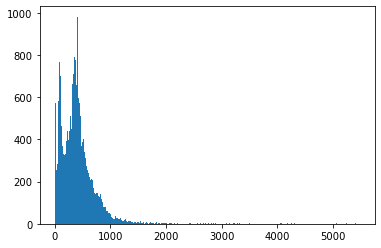

In [35]:
plt.hist([len(x) for x in X], bins = 700)
plt.show()

In [36]:
nos = np.array([len(x) for x in X])
len( nos[nos>1000])

1583

In [37]:
max_len = 1000
X= pad_sequences(X, maxlen = max_len)

In [38]:
vocab_size = len(tokenizer.word_index) + 1
vocab = tokenizer.word_index

In [39]:
def get_weight_matrix(model):
  weight_matrix = np.zeros((vocab_size, DIM))

  for word, i in vocab.items():
    weight_matrix[i]= model.wv[word]
  
  return weight_matrix

In [40]:
embedding_vector = get_weight_matrix(w2v_model)

In [41]:
# creating the model 

model= Sequential()
model.add(Embedding(vocab_size, output_dim = DIM, weights = [embedding_vector], input_length= max_len, trainable = False))
model.add(LSTM(units = 128))
model.add(Dense(1, activation = 'sigmoid'))
model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['acc'])

In [42]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 1000, 100)         25251700  
                                                                 
 lstm (LSTM)                 (None, 128)               117248    
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 25,369,077
Trainable params: 117,377
Non-trainable params: 25,251,700
_________________________________________________________________


In [43]:
X_train, X_test, y_train, y_test = train_test_split(X,y)

In [44]:
model.fit(X_train, y_train, validation_split= 0.3, epochs = 6 )

Epoch 1/6
737/737 [==============================] - 430s 582ms/step - loss: 0.1384 - acc: 0.9505 - val_loss: 0.0766 - val_acc: 0.9759
Epoch 2/6
737/737 [==============================] - 422s 572ms/step - loss: 0.0698 - acc: 0.9768 - val_loss: 0.0633 - val_acc: 0.9786
Epoch 3/6
737/737 [==============================] - 445s 604ms/step - loss: 0.0511 - acc: 0.9832 - val_loss: 0.0550 - val_acc: 0.9827
Epoch 4/6
737/737 [==============================] - 459s 622ms/step - loss: 0.0399 - acc: 0.9877 - val_loss: 0.0304 - val_acc: 0.9909
Epoch 5/6
737/737 [==============================] - 459s 623ms/step - loss: 0.0241 - acc: 0.9918 - val_loss: 0.0262 - val_acc: 0.9917
Epoch 6/6
737/737 [==============================] - 445s 604ms/step - loss: 0.0096 - acc: 0.9968 - val_loss: 0.0194 - val_acc: 0.9946


In [45]:
y_pred = (model.predict(X_test) >=0.5).astype(int)

In [46]:
accuracy_score(y_test, y_pred)

0.9924309884238647

In [47]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      0.99      0.99      5896
           1       0.99      0.99      0.99      5334

    accuracy                           0.99     11230
   macro avg       0.99      0.99      0.99     11230
weighted avg       0.99      0.99      0.99     11230

